### Import libraries

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

from fredapi import Fred

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import TimeSeriesSplit

### Helpers

In [ ]:
#########################
## Feature engineering ##
#########################

def create_ohlc_features(df, horizons=[2, 5, 10, 15, 20,60,100]):
    predictors = []

    for horizon in horizons:
        rolling_averages = df.rolling(horizon).mean()
        df[f"Close_Ratio_{horizon}"] = df["close"] / rolling_averages["close"]
        df[f"Trend_{horizon}"] = df.shift(1).rolling(horizon).sum()["target"]
        df[f"Volatility_{horizon}"] = df["close"].rolling(horizon).std()
        df[f"Momentum_{horizon}"] = df["close"] - df["close"].shift(horizon)
        df[f"EMA_{horizon}"] = df["close"].ewm(span=horizon, adjust=False).mean()
        df["Cumulative_Return"] = df["close"].pct_change().cumsum()

        predictors += [
            f"Close_Ratio_{horizon}",
            f"Trend_{horizon}",
            f"Volatility_{horizon}",
            f"Momentum_{horizon}",
            f"EMA_{horizon}",
            "Cumulative_Return",
        ]

    df = df.dropna()  
    return df, predictors

def create_interest_rate_features(df):
    # First-order difference (rate of change)
    df["Interest_Rate_Change"] = df["rates"].diff()

    # Second-order difference (change in rate of change)
    df["Interest_Rate_Change_Diff"] = df["Interest_Rate_Change"].diff()

    # Previous period rate change indicator
    df["Previous_Rate_Direction"] = df["Interest_Rate_Change"].shift(1).apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # List of predictors
    predictors = [
        "Interest_Rate_Change",
        "Interest_Rate_Change_Diff",
        "Previous_Rate_Direction",
    ]

    return df, predictors

def create_calendar_features(df, date_col):
 
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Calendar features
    df["day_of_week"] = df[date_col].dt.dayofweek
    df["day_of_month"] = df[date_col].dt.day
    df["week_of_year"] = df[date_col].dt.isocalendar().week
    df["month"] = df[date_col].dt.month
    df["year"] = df[date_col].dt.year
    df["quarter"] = df[date_col].dt.quarter
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)

    # Cyclical encoding
    df["day_of_week_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_of_week_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # List of generated features
    predictors = [
        "day_of_week",
        "day_of_month",
        "week_of_year",
        "month",
        "year",
        "quarter",
        "is_month_end",
        "is_month_start",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
    ]

    return df, predictors



#################
## Backtesting ##
#################

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=1000, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)


#############
## helpers ##
#############

def convert_date_format(date_string):
    main_date_part = date_string.split(" (")[0]  
    parsed_date = datetime.strptime(main_date_part, "%b %d, %Y") 
    return parsed_date.strftime("%Y-%m-%d")


### Bring data

In [6]:
fredapikey = "2128c9d039210886d2dbd0e7b35ac1c1"
fred = Fred(api_key=fredapikey)

start_date = '2020-01-01'
end_date = '2024-12-30'
# today_date = datetime.today().strftime('%Y-%m-%d')

zf = yf.download('ZF=F', start=start_date,end=end_date)
zf.reset_index(inplace=True)
zf.head()

df = zf.copy()
df.drop(columns=['Adj Close'],inplace=True)
df.columns = ['date','open','high','low','close','volume']
df.shape

[*********************100%***********************]  1 of 1 completed


(1246, 6)

### Create Targets

In [7]:
df['tomorrow'] = df['close'].shift(-1)
df['target'] = (df['tomorrow'] > df['close']).astype(int)
df.head()

,date,open,high,low,close,volume,tomorrow,target
0,2020-01-02,118.531250,118.851562,118.460938,118.664062,736650,119.062500,1
1,2020-01-03,118.679688,119.109375,118.671875,119.062500,868998,118.960938,0
2,2020-01-06,119.101562,119.210938,118.898438,118.960938,859162,118.921875,0
3,2020-01-07,118.953125,119.046875,118.906250,118.921875,746424,118.695312,0
4,2020-01-08,118.976562,119.523438,118.679688,118.695312,1225252,118.742188,1


### Baseline Model

In [8]:
model = RandomForestClassifier(random_state=1)

train = df.iloc[:-300]
test = df.iloc[-300:]

predictors = ["close", "volume", "open", "high", "low"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(random_state=1)

<AxesSubplot: >

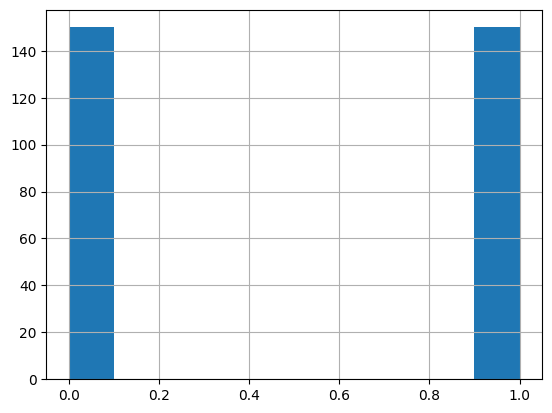

In [9]:
test['target'].hist()

In [10]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds) * 100

53.90625

In [22]:
predictions = pd.DataFrame({
    'target': test['target'],
    'prediction':preds
})

predictions.head(3)

,target,prediction
946,0,0
947,1,1
948,0,0


In [26]:
predictions.query('target ==1 and prediction ==1').shape[0]/ test[test['target'] == 1].shape[0]

0.46

### Backtesting

In [28]:
predictions = backtest(df, model, predictors)


In [29]:
predictions["Predictions"].value_counts()


0    124
1    122
Name: Predictions, dtype: int64

In [30]:
precision_score(predictions["target"], predictions["Predictions"])


0.5573770491803278

In [31]:
predictions["target"].value_counts() / predictions.shape[0]


0    0.512195
1    0.487805
Name: target, dtype: float64

### Macro Data 

In [4]:
### Uneployment Rate ###
un_rate = pd.read_excel("Low frequency data.xlsx",sheet_name="Unemployment Rate")
un_rate['un_announcement'] = 1
un_rate.columns = ['date','time','actual','forecast','previous','un_announcement']
un_rate['date'] = un_rate['date'] .apply(convert_date_format)
un_rate['unempl_change'] = un_rate['forecast'] - un_rate['previous']
del un_rate['time'], un_rate['previous'], un_rate['forecast'], un_rate['actual']
un_rate.to_csv('unemployment.csv',index_label=False)

### CPI ###
cpi = pd.read_excel("Low frequency data.xlsx",sheet_name="CPI")
cpi['cpi_announcement'] = 1
cpi.columns = ['date','time','actual','forecast','previous','cpi_announcement']
cpi['date'] = cpi['date'].apply(convert_date_format)
cpi['cpi_change'] = cpi['forecast'] - cpi['previous']
del cpi['time'], cpi['previous'], cpi['forecast'], cpi['actual']
cpi.to_csv('cpi.csv',index_label=False)

### Fed rates ### 
interest_rates = pd.read_excel('Low frequency data.xlsx', sheet_name='Fed Interest Rate')
interest_rates['interest_announcement'] = 1
interest_rates.columns = ['date','time','actual','forecast','previous','interest_announcement']
interest_rates['interest_change'] = interest_rates['forecast'] - interest_rates['previous']
del interest_rates['time'],interest_rates['previous'], interest_rates['forecast'], interest_rates['actual']
interest_rates.to_csv('interest_rate.csv',index_label=False)

NameError: name 'convert_date_format' is not defined

### Feature Addition

### Feature Selection

### Evaluation